In [1]:
import numpy as np
import time
from scipy import misc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import pandas as pd
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

In [2]:
M=1000
ite=10
block=0
T=1
T_c=1
T_f=0.1
delta_c=torch.tensor(T_c/ite)
delta_f=torch.tensor(T_f/ite)
a=1
b=1
c=1
d=1
A=1
B=1
sigma=0.01
alpa=1
beta=1
neuron_model_psi=20
dim_n=2
up_lim=100
print(delta_c,delta_f)

tensor(0.1000) tensor(0.0100)


In [3]:
model_f= torch.nn.Sequential(
    torch.nn.Linear(dim_n, neuron_model_psi),
    torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi,1)
)

In [4]:
model_coarse = torch.load('model_N10_LQC.pth')

In [5]:
def update(x3,psi,z,i,delta):
    t=(x3[:,0]+(T_f/ite))
    #print(x3[:,1].shape,z[:,i].shape,psi.shape)
    x=x3[:,1]+(c*x3[:,1]+d*psi)*delta+sigma*torch.sqrt(delta)*z[:,i]
    up=torch.cat((t.unsqueeze(1),x.unsqueeze(1)),dim=1)
#     print('up shape=', up.shape)
    return up

def update_for_V(x3,psi,z,i,delta):
    t=(x3[:,0]+(T_c/ite))
    #print(x3[:,1].shape,z[:,i].shape,psi.shape)
    x=x3[:,1]+(c*x3[:,1]+d*psi)*delta+sigma*torch.sqrt(delta)*z[:,i]
    up=torch.cat((t.unsqueeze(1),x.unsqueeze(1)),dim=1)
    return up
    
def loss_func(x2,psi):
    loss=a*torch.pow(x2[:,1],2)+b*x2[:,1]+A*torch.pow(psi,2)+B*psi
    return loss

def loss_func_ter(x4,f,h,k,state_data):
#     loss=alpa*torch.pow(x4[:,1],2)+beta*x4[:,1]
    v_f=0.0

    for i in range(1,ite+1):
#         v_f=v_f+f[i]*torch.pow (x4[:,1],2)+h[i]*x4[:,1]+k[i]
        if i==block+1:
            v_f=v_f+f[i]*torch.pow(x4[:,1],2)+h[i]*x4[:,1]+k[i]
# #         else:
# #             v_f=v_f+f[i]*torch.pow(state_data[i-1,:,1],2)+h[i]*state_data[i-1,:,1]+k[i]
# #     v_f=(0.9*v_f)/(ite)
    return v_f

# def loss_func_ter(x4,f,h,k,state_data):
#     #loss=alpa*torch.pow(x4[:,1],2)+beta*x4[:,1]
#     v_f=0.0

#     for i in range(1,ite+1):
#         psi=model_f(x4).squeeze(1).detach()
# #         v_f=v_f+f[i]*torch.pow (x4[:,1],2)+h[i]*x4[:,1]+k[i]
#         if i==1:
#             v_f=v_f+f[i]*torch.pow(x4[:,1],2)+h[i]*x4[:,1]+k[i]
#         else:
#             x4=update_for_V(x4,psi,z,i,delta_f)
#             v_f=v_f+f[i]*torch.pow(x4[:,1],2)+h[i]*x4[:,1]+k[i]
#     v_f=v_f/(ite)
#     return v_f

# def loss_func_ter(x4,f,h,k,state_data):
#     V=torch.zeros(M,ite)
#     for i in range(ite,0,-1):
#         if (i==ite):
#             V[:,i-1]=alpa*torch.pow(state_data[i-1,:,1],2)+beta*state_data[i-1,:,1]  
#         elif(i>1):
#             psi=model_f(state_data[i-1,:,:]).squeeze(1).detach()
#             V[:,i-1]=V[:,i]+(a*torch.pow(state_data[i-1,:,1],2)+b*state_data[i-1,:,1]+A*torch.pow(psi,2)+B*psi)*delta_c       
#         else:
#             V[:,i-1]=f[i]*torch.pow (x4[:,1],2)+h[i]*x4[:,1]+k[i]
#     loss_ter=(torch.sum(V,dim=1))/ite
#     return loss_ter
        

# def unit(x1,model,i,delta):
#     psi=model(x1).squeeze(1)
#     return loss

def unit(x1,model,i,delta):
    psi=model(x1).squeeze(1)
    los=loss_func(x1,psi)
    upd=update(x1,psi,z,i,delta)
    #print('unit print=',psi.shape,los.shape,upd.shape)
    return psi,los,upd

def loss_func_total(u,model,delta,f,h,k,state_data):
    loss=torch.zeros(M,ite)
    psi=torch.zeros(M,ite)
    for i in range(ite+1):
        if(i<ite):
            psi_run,loss_run,u_run=unit(u,model,i,delta)
            #print('los func=',psi_run.shape,loss_run.shape)
            loss[:,i]=loss_run
            #print(loss)
            psi[:,i]=psi_run
            #print(psi)
            u=u_run
          #print(u)
        else:
            loss_ter=loss_func_ter(u,f,h,k,state_data)
          #print('ter',loss_ter.shape)
        #print(torch.sum(loss,dim=1))
    loss=torch.sum(loss,dim=1)*delta+loss_ter
    return torch.mean(loss)

In [6]:
def testing_coarse(M1,ite,up_lim,delta):
    x_ar=[]
    z1=torch.randn(size=(M1,ite))
    t_test=torch.zeros([M1,1])
    x1=torch.linspace(0.3*up_lim,0.7*up_lim, steps=M1).unsqueeze(1)
    x_test=torch.cat((t_test,x1),dim=1)
    pred_soln=torch.zeros(M1,ite)
    for i in range(ite):
        x_ar.append(x_test[:,1].numpy())
        soln_pred=model_coarse.eval()(x_test).squeeze(1).detach()
        pred_soln[:,i]=soln_pred
        x_test=update(x_test,soln_pred,z1,i,delta)
    x_ar.append(x_test[:,1].numpy())
    state_var=np.squeeze(np.array(x_ar))
    state_var=state_var.transpose()
    return state_var,pred_soln

In [7]:
data=np.load('state_var_dic_N10.npz')
state_data = torch.tensor(data['state variable'])
# print(state_data.shape)
#print(state_data[0,:,:])

In [8]:
M1=5
x_c,c_soln=testing_coarse(M1,ite,up_lim,delta_c)
x_c=torch.tensor(x_c)
x_max=torch.max(x_c)
t=torch.zeros([M,1])
#x=torch.FloatTensor(M,1).uniform_(0.0,up_lim)
element=state_data[block,:,1].reshape(1000,1)
z=torch.randn(size=(M, ite+1))
x=torch.cat((t,element),dim=1)
print('coarse soution=',c_soln[0])
print(x.shape)

coarse soution= tensor([-62.6734, -55.8124, -49.8449, -44.4978, -39.4819, -34.8253, -31.0569,
        -27.7677, -24.8311, -22.1903])
torch.Size([1000, 2])


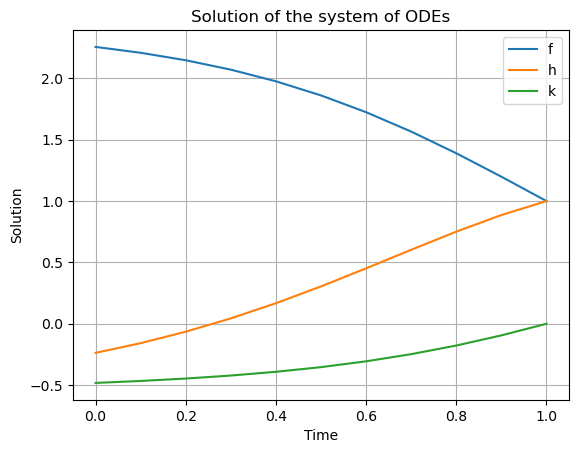

In [9]:
# Define the system of ODEs
def system_of_odes(t, y):
    dydt = [
        a+2*c*y[0]-(d**2*y[0]**2)/A,                 # df/dt = a+2cf-d^2*f^2/A; f(0)=alpa
        b-(B+d*y[1])*d*y[0]/A,                       # dh/dt = b-(B+dh)fd/A; h(0)=beta
        sigma**2*y[0]-(B+d*y[1])**2/(4*A)        # dk/dt = sigma^2*f-(B+dh)^2/4A; k(0)=0
    ]
    return dydt

# Initial conditions
initial_conditions = [alpa, beta, 0]  # Initial values for y1, y2, and y3

# Time span
t_span = (0, T_c)  # Start and end time

# Solve the system of ODEs
sol = solve_ivp(system_of_odes,t_span, initial_conditions, t_eval=np.linspace(0, T_c, ite+1))

f=np.flip(sol.y[0])
h=np.flip(sol.y[1])
k=np.flip(sol.y[2])
# Plot the solution
plt.plot(sol.t, f, label='f')
plt.plot(sol.t, h, label='h')
plt.plot(sol.t, k, label='k')
plt.xlabel('Time')
plt.ylabel('Solution')
plt.title('Solution of the system of ODEs')

plt.legend()
plt.grid(True)
plt.show()

In [10]:
start=time.time()
lr1 = 8e-3
max_epoch = 3000
cost_ar=[]
optimizer = optim.Adam(model_f.parameters(), lr1)

#print(psi.shape)
for epoch in range(max_epoch):
  optimizer.zero_grad()
  cost=loss_func_total(x,model_f,delta_f,f,h,k,state_data)
  cost.backward()
  optimizer.step()
  cost_ar.append(cost)
  #print(loss.item())
  if (epoch % 100==0):
    print("At epoch {} the mean cost is {}.".format(epoch,cost.detach()))
end=time.time()
total_time=end-start
print('time elapsed=',total_time)

At epoch 0 the mean cost is 6996.251953125.
At epoch 100 the mean cost is 5851.3095703125.
At epoch 200 the mean cost is 5851.30615234375.
At epoch 300 the mean cost is 5851.30419921875.
At epoch 400 the mean cost is 5851.30078125.
At epoch 500 the mean cost is 5851.298828125.
At epoch 600 the mean cost is 5851.296875.
At epoch 700 the mean cost is 5851.2939453125.
At epoch 800 the mean cost is 5851.29296875.
At epoch 900 the mean cost is 5851.2919921875.
At epoch 1000 the mean cost is 5851.2900390625.
At epoch 1100 the mean cost is 5851.2890625.
At epoch 1200 the mean cost is 5851.28857421875.
At epoch 1300 the mean cost is 5851.287109375.
At epoch 1400 the mean cost is 5851.287109375.
At epoch 1500 the mean cost is 5851.28515625.
At epoch 1600 the mean cost is 5851.28515625.
At epoch 1700 the mean cost is 5851.28369140625.
At epoch 1800 the mean cost is 5851.283203125.
At epoch 1900 the mean cost is 5851.2822265625.
At epoch 2000 the mean cost is 5851.28076171875.
At epoch 2100 the m

In [29]:
M2=1
x_ar=[]
print(delta_f)
z1=torch.randn(size=(M2,ite))
t_test=torch.zeros([M2,1])
x1=torch.linspace(0.7*up_lim,0.9*up_lim, steps=M2).unsqueeze(1)
x_test=torch.cat((t_test,x1),dim=1)
#pred_soln=torch.zeros(M2,ite)
pred_soln=[]
for i in range(ite):
    for j in range(ite):        
        x_ar.append(x_test[:,1].numpy())
        soln_pred=model_f.eval()(x_test).squeeze(1).detach()
        #print(soln_pred)
        #pred_soln[:,i]=soln_pred
        pred_soln.append(soln_pred.numpy())
        x_test=update(x_test,soln_pred,z1,j,delta_f)
        if(torch.floor(x_test[0,0]*10)!=0):
            x_test[:,0]=0.0
        #x_ar.append(x_test[:,1].numpy())
state_var=np.squeeze(np.array(x_ar))
state_var=state_var.transpose()
pred=np.squeeze(np.array(pred_soln))
pred=pred.transpose()

tensor(0.0100)


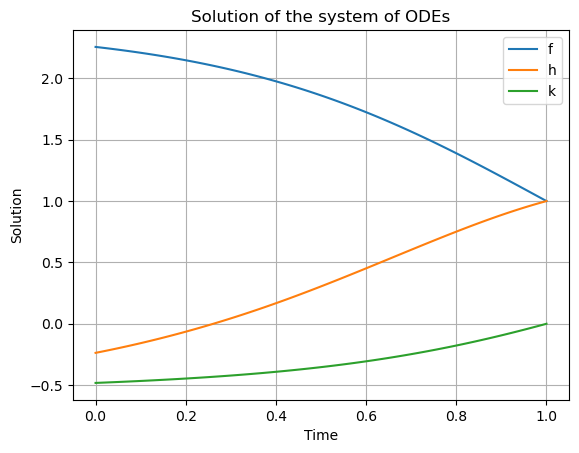

In [30]:
# Define the system of ODEs
def system_of_odes(t, y):
    dydt = [
        a+2*c*y[0]-(d**2*y[0]**2)/A,                 # df/dt = a+2cf-d^2*f^2/A; f(0)=alpa
        b-(B+d*y[1])*d*y[0]/A,                       # dh/dt = b-(B+dh)fd/A; h(0)=beta
        sigma**2*y[0]-(B+d*y[1])**2/(4*A)        # dk/dt = sigma^2*f-(B+dh)^2/4A; k(0)=0
    ]
    return dydt

# Initial conditions
initial_conditions = [alpa, beta, 0]  # Initial values for y1, y2, and y3

# Time span
t_span = (0, T_c)  # Start and end time

# Solve the system of ODEs
sol = solve_ivp(system_of_odes,t_span, initial_conditions, t_eval=np.linspace(0, T_c, 100))

f=np.flip(sol.y[0])
h=np.flip(sol.y[1])
k=np.flip(sol.y[2])
# Plot the solution
plt.plot(sol.t, f, label='f')
plt.plot(sol.t, h, label='h')
plt.plot(sol.t, k, label='k')
plt.xlabel('Time')
plt.ylabel('Solution')
plt.title('Solution of the system of ODEs')

plt.legend()
plt.grid(True)
plt.show()

In [31]:
def optimal_soln(x,f,h):
    u=-(B+d*(2*x*f+h))/(2*A)
    return u

def value_func(x,f,h,k):
    V=f*x**2+h*x+k
    return V

def total_cost(x,u):
    cost_run=0.0
    for i in range(ite+1):
        if(i<ite):
            cost_run=cost_run+a*x[i]**2+b*x[i]+A*u[i]**2+B*u[i]
        else:
            cost_ter=alpa*x[i]**2+beta*x[i]
    return cost_run*delta_f.numpy()+cost_ter 

In [32]:
t_eval=np.linspace(0,T_c,100)
u=optimal_soln(state_var,f,h)
V=value_func(state_var,f,h,k)

print('state variable',state_var)
print('\n True solution',u)
true_cost=total_cost(state_var,u)
print('\n True cost=',true_cost)
print('\n Predicted solution',pred)
pred_cost=total_cost(state_var,pred)
print('\n Predicted cost=',pred_cost)
print('Absolute Error',np.abs(u)-np.abs(pred))
print('Percent Error in cost=',np.abs(100*(np.abs(true_cost)-np.abs(pred_cost))/true_cost),'%\n')

state variable [70.       69.14654  68.304596 67.472984 66.65419  65.84462  65.04714
 64.260254 63.48283  62.716263 61.96052  61.21382  60.466793 59.728943
 59.00278  58.28472  57.57765  56.880074 56.19088  55.511482 54.841854
 54.180225 53.527805 52.872856 52.228596 51.591446 50.964306 50.345695
 49.734516 49.132187 48.538696 47.952286 47.374172 46.803192 46.231327
 45.6657   45.109215 44.560406 44.018185 43.48398  42.957787 42.437862
 41.925434 41.419346 40.922146 40.419724 39.92568  39.438557 38.957275
 38.483273 38.01656  37.555393 37.101013 36.65227  36.211723 35.77583
 35.33695  34.904324 34.47688  34.056065 33.641895 33.23264  32.82954
 32.43146  32.040966 31.654516 31.275045 30.890549 30.510654 30.136812
 29.769049 29.40564  29.04783  28.694494 28.3482   28.005419 27.66909
 27.337774 26.999857 26.667484 26.34069  26.017756 25.69993  25.386095
 25.078825 24.774597 24.476355 24.182665 23.892479 23.5967   23.306059
 23.018839 22.736298 22.45732  22.184484 21.914276 21.649641 21.38

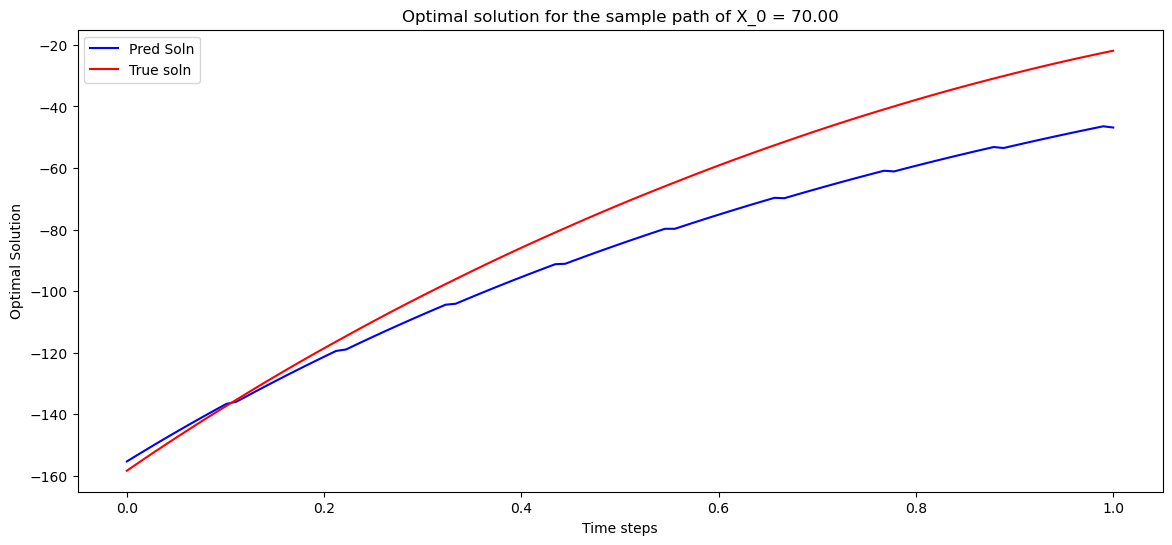

In [33]:
plt.figure(figsize=(14,6))
plt.plot(t_eval,pred, color='b', label='Pred Soln')
plt.plot(t_eval,u, color='r', label='True soln')
plt.xlabel('Time steps')
plt.ylabel('Optimal Solution')
plt.title(f'Optimal solution for the sample path of X_0 = {state_var[0]:.2f}')
plt.legend()
plt.show()

In [16]:
# t_eval=np.linspace(0,T_c,100)
# u=optimal_soln(state_var[:, :-1],f,h)
# V=value_func(state_var[:, :-1],f,h,k)
# pred=pred_soln.numpy()
# for i in range(M2):
#     print('state variable',state_var[i])
#     print('\n True solution',u[i])
#     true_cost=total_cost(state_var[i],u[i])
#     print('\n True cost=',true_cost)
#     print('\n Predicted solution',pred[i])
#     pred_cost=total_cost(state_var[i],pred[i])
#     print('\n Predicted cost=',pred_cost)
#     print('Percent Error in cost=',np.abs(100*(np.abs(true_cost)-np.abs(pred_cost))/true_cost),'%\n')

In [17]:
# import matplotlib.pyplot as plt
# # Create subplots
# fig, axs = plt.subplots(ite-80, 1, figsize=(9, 20))
# state_var=state_var[:, :-1]
# for i, ax in enumerate(axs):
#     ax.scatter(state_var[:,i],pred[:,i],color='r',label='X vs Pred', marker='o')
#     ax.scatter(state_var[:,i],u[:,i], color='blue', label='X vs True', marker='*')
#     ax.set_xlabel('State Variable X')
#     ax.set_ylabel('Optimal Soln')
#     ax.set_title(f'Optimal Solution at Time Step {i}')
#     ax.legend()
# # Adjust layout
# plt.tight_layout()
# plt.show()

In [18]:

# fig, axs = plt.subplots(M1,1, figsize=(6, 25))

# # Plot x vs y and x vs z on each subplot
# for i, ax in enumerate(axs):
#     ax.plot(t_eval,pred[i], color='b', label='Pred Soln')
#     ax.plot(t_eval,u[i], color='r', label='True soln')
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Optimal Solution')
#     ax.set_title(f'Optimal solution for the sample path of X_0 = {state_var[i,0]:.2f}')
#     ax.legend()

# # Adjust layout
# plt.tight_layout()

# # Show plot
# plt.show()